# Make ACTN2 Affimer PERPL analysis plots

## Imports

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from perpl.modelling import modelling_general, zdisk_modelling, zdisk_plots
from perpl.io import plotting

## Set average estimated localisation precision for Affimer and PALM data.
This is the mean after filtering for localisation precision < 5 nm.

In [2]:
af647_precision = 3.1 # Mean value after filtering for precision < 5 nm

## Set standard maximum distance over which to plot distances and fit models.

In [3]:
fitlength = 100.

## Choose Affimer relative position data and combine files if necessary
### Insert paths to the Affimer relative position data here:

In [18]:
actn_affimer_relpos_path = r"../../perpl_test_data/ACTN2-Affimer_PERPL-relpos_200.0filter_len2440488.pkl"

### Select desired datasets to combine here:
These contain all data attributes, including the relative positions in both directions for each pair of localisations. We will filter e.g. for cell-axial data later.

In [19]:
path_list = [actn_affimer_relpos_path]
print(path_list)
relpos = zdisk_modelling.read_relpos_from_pickles(path_list)

['../../perpl_test_data/ACTN2-Affimer_PERPL-relpos_200.0filter_len2440488.pkl']


### Data attributes and number of data points:

In [20]:
relpos.iloc[0, :] # This shows the first relative position.

axial          49.426791
perpaxis2D     34.358846
tocoverslip    15.602947
z_nzcorr       16.072208
transverse     37.932126
Name: 0, dtype: float64

In [21]:
len(relpos) # This shows how many relative positions.

2440488

## Get the axial (X) distances, without duplicates
The YZ-distance limit for pairs of localisations to include can be set here.

In [22]:
# This is the YZ-distance limit for X-distances to include:
transverse_limit = 10.

axial_distances = zdisk_modelling.getaxialseparations_no_smoothing(
    relpos,
    max_distance=relpos.axial.max(),
    transverse_limit=transverse_limit
    )
axial_distances = zdisk_modelling.remove_duplicates(axial_distances)

## Get the 1-nm bin histogram data
Up to distance = fitlength

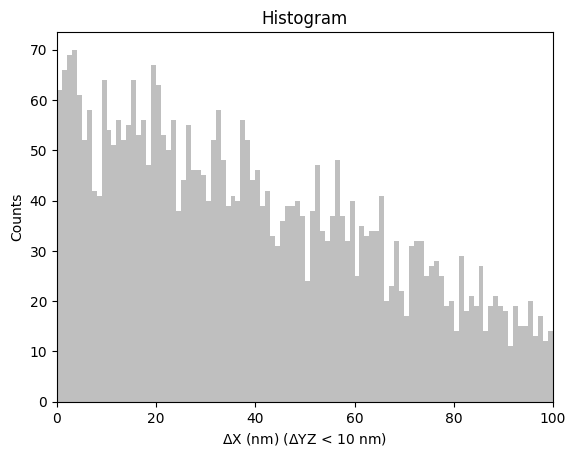

In [23]:
hist_values, bin_edges = zdisk_plots.plot_distance_hist(
    axial_distances,
    fitlength
    )
bin_centres = (bin_edges[0:(len(bin_edges) - 1)]
               + bin_edges[1:]
               ) / 2

## Get the KDE data
Estimate every 1 nm, with kernel size based on localisation precision estimate.

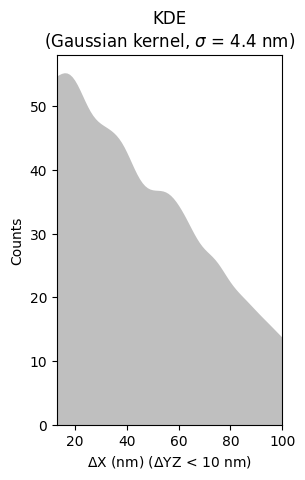

In [24]:
kde_x_values, kde = zdisk_plots.plot_distance_kde(
    axial_distances,
    af647_precision,
    100.
    )

## Calculate the axial RPD with smoothing for Churchman 1D function

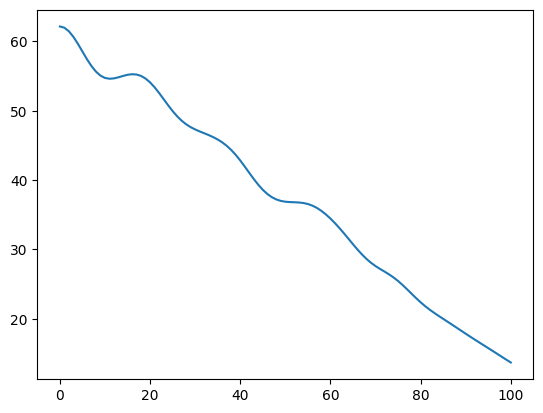

In [25]:
calculation_points = np.arange(fitlength + 1.)
axial_rpd = plotting.estimate_rpd_churchman_1d(
    input_distances=axial_distances,
    calculation_points=calculation_points,
    combined_precision=(np.sqrt(2) * af647_precision)
)
plt.plot(calculation_points, axial_rpd)

## Choose axial model:

In [26]:
axial_model_with_info = zdisk_modelling.set_up_model_4_peaks_fixed_ratio_with_fit_settings()


## Fit model to histogram bin values, at bin centres

In [27]:
(params_optimised,
 params_covar,
 params_1sd_error) = zdisk_modelling.fitmodel_to_hist(
    bin_centres,
    hist_values,
    axial_model_with_info.model_rpd,
    axial_model_with_info.initial_params,
    axial_model_with_info.param_bounds,
    )
print('')
print('Initial parameter guesses:')
print(axial_model_with_info.initial_params)
print('')
print('Parameter bounds:')
print(axial_model_with_info.param_bounds)

[[ 1.84232738e+01  5.82050327e-01]
 [ 5.32021231e+00  2.03040867e+00]
 [ 2.00439672e+02  2.36048818e+02]
 [ 2.92530452e+00  1.72292814e+00]
 [ 1.00564895e+02  1.26309485e+02]
 [-3.53903113e-01  1.65615014e-01]
 [ 4.93485145e+01  1.53984550e+01]]
SSR = 3206.2433353407955
AIC = 362.7685044282682
AICcorr = 364.3509220106858

Initial parameter guesses:
[20, 5, 1, 3, 1, -0.2, 20]

Parameter bounds:
([0, 0, 0, 0, 0, -100, 0], [50, 20, 1000, 20, 1000, 100, 100])


## Plot fitted model over histogram data

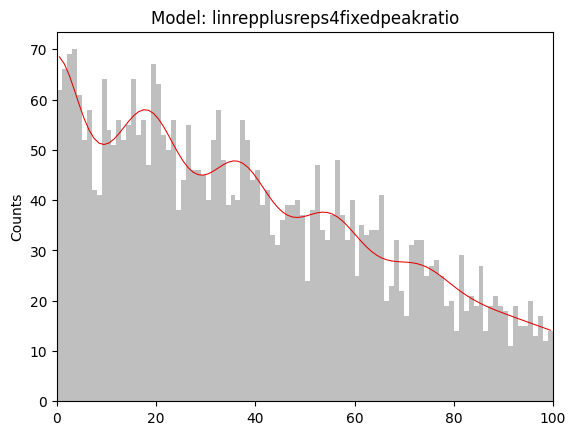

In [28]:
fig, axes = zdisk_plots.plot_distance_hist_and_fit(
    axial_distances,
    fitlength,
    params_optimised,
    params_covar,
    axial_model_with_info
)

## Plot fitted model over histogram data, with confidence intervals on the model
### NOTE: IT TAKES A WHILE TO CALCULATE THE CONFIDENCE INTERVALS
### Skip this if you don't need it right now.

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Model: linrepplusreps4fixedpeakratio'}, ylabel='Counts'>)

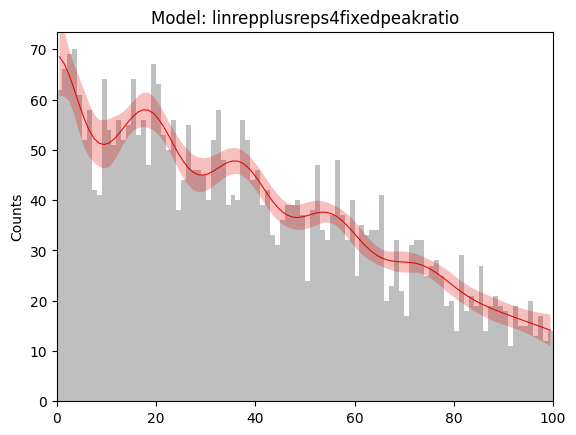

In [29]:
zdisk_plots.plot_distance_hist_and_fit(
    axial_distances,
    fitlength,
    params_optimised,
    params_covar,
    axial_model_with_info,
    plot_95ci=True
)

## Akaike weights for the models
Typed in AICc values for the different models here, to obtain relative likelihood, summing to one:

In [33]:
from perpl.statistics.modelstats import akaike_weights
weights = akaike_weights([
    364.35,
    364.51,
    366.38,
    370.28,
    374.67
])
print(weights)

[0.42683586 0.39401916 0.15468635 0.02200786 0.00245076]


## Plot model components for best model (4 peaks with fixed peak ratio)

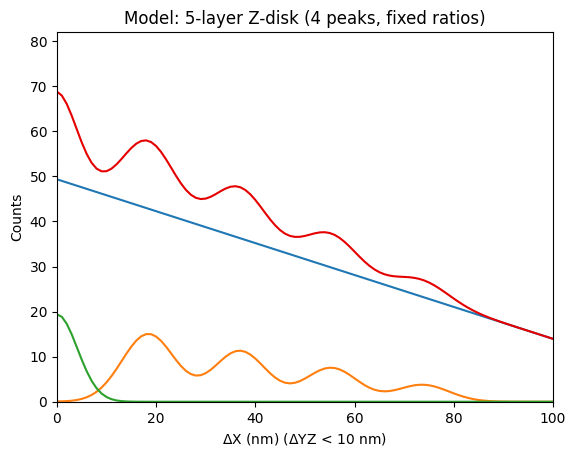

In [34]:
zdisk_plots.plot_model_components_4peaks_fixed_peak_ratio(
    fitlength,
    *params_optimised)

# Transverse distances

## Get the transverse (YZ) distances, without duplicates
The X-distance limit for pairs of localisations to include can be set here.

In [35]:
# This is the YZ-distance limit for X-distances to include:
axial_limit = 10.
print(relpos.shape)

trans_distances = zdisk_modelling.get_transverse_separations(
    relpos,
    max_distance=relpos.transverse.max(),
    axial_limit=axial_limit
    )
trans_distances = zdisk_modelling.remove_duplicates(trans_distances)

(2440488, 5)


## Choose analysis lengthscale for transverse distance

In [36]:
fitlength = 50.

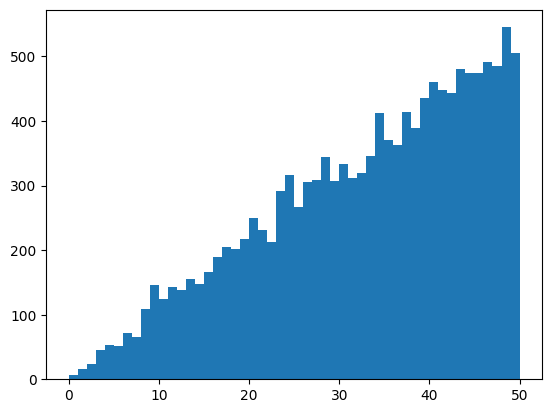

In [37]:
hist_1nm_bins = plt.hist(trans_distances, bins=np.arange(fitlength + 1.))

## Estimate RPD using Churchman's function

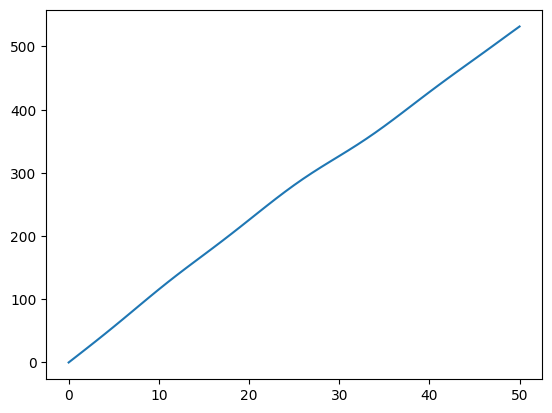

In [38]:
fitlength = 50.
calculation_points = np.arange(fitlength + 1.)
combined_precision= np.sqrt(2) * af647_precision
transverse_rpd = plotting.estimate_rpd_churchman_2d(
    input_distances=trans_distances[trans_distances < (fitlength + 3 * combined_precision)],
    calculation_points=calculation_points,
    combined_precision=combined_precision
)
plt.plot(calculation_points, transverse_rpd)

## Normalise for increasing search circle with increasing distance

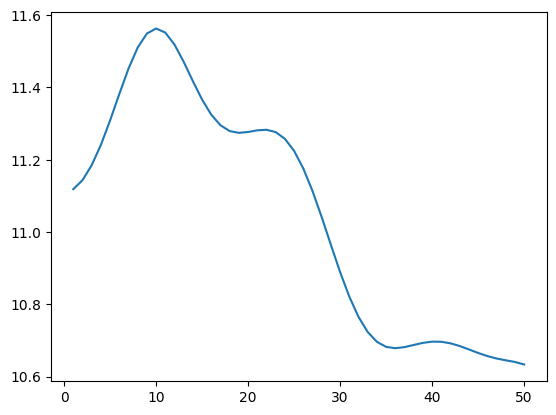

In [39]:
normalised_transverse_rpd = transverse_rpd[calculation_points > 0.] / calculation_points[calculation_points > 0.]
norm_rpd_calculation_points = calculation_points[calculation_points > 0.]
plt.plot(norm_rpd_calculation_points, normalised_transverse_rpd)

### 1 nm-bin  histogram result for comparison

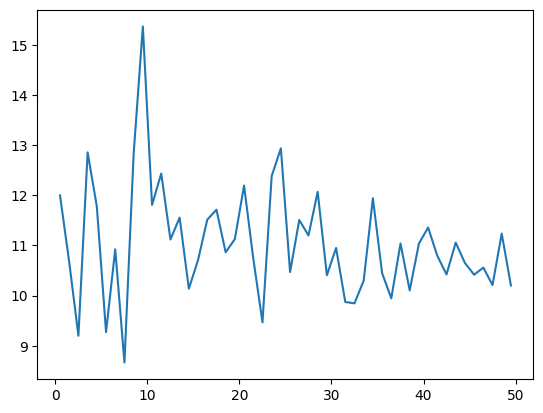

In [40]:
plt.plot(hist_1nm_bins[1][0:-1] + 0.5, hist_1nm_bins[0]/(hist_1nm_bins[1][0:-1] + 0.5))

### Optional save/load to save time

In [41]:
np.save('normalised_transverse_rpd_smoothed_Churchman-4p4', normalised_transverse_rpd)
# normalised_transverse_rpd = np.load('normalised_transverse_rpd_smoothed_Churchman-4p4.npy')

## Set up an RPD model and fit
I've tried a few smoothing kernel widths here.

In [42]:
trans_model_with_info = zdisk_modelling.set_up_model_2d_onepeak_plus_replocs_flat_bg_with_fit_settings()

In [43]:
(params_optimised,
 params_covar,
 params_1sd_error) = zdisk_modelling.fitmodel_to_hist(
    norm_rpd_calculation_points[0:31],
    normalised_transverse_rpd[0:31],
    trans_model_with_info.model_rpd,
    trans_model_with_info.initial_params,
    trans_model_with_info.param_bounds
    )
print('')
print('Initial parameter guesses:')
print(trans_model_with_info.initial_params)
print('')
print('Parameter bounds:')
print(trans_model_with_info.param_bounds)

[[2.43141185e+01 7.95260239e+00]
 [1.32122024e+01 7.60252146e+00]
 [1.00000000e+03 2.23903918e+03]
 [5.22872045e+00 6.71302226e-01]
 [5.38929520e+00 1.10246565e+00]
 [9.87608062e+00 2.01822018e+00]]
SSR = 0.0725867947235297
AIC = -173.76574354027576
AICcorr = -168.89617832288445

Initial parameter guesses:
[20, 5, 1, 3, 1, 20]

Parameter bounds:
([0, 0, 0, 0, 0, 0], [50, 20, 1000, 20, 1000, 100])


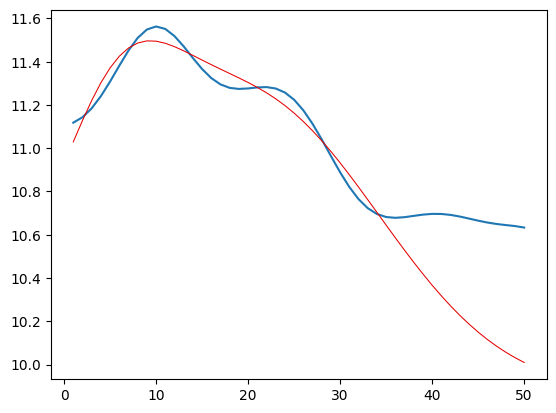

In [44]:
plt.plot(norm_rpd_calculation_points,
    normalised_transverse_rpd)
zdisk_plots.plot_fitted_model(
    norm_rpd_calculation_points,
    fitlength,
    params_optimised,
    params_covar,
    trans_model_with_info,
    plot_95ci=False
    )

In [45]:
fitlength = 50.
calculation_points = np.arange(fitlength + 1.)
combined_precision=8.
transverse_rpd_s8 = plotting.estimate_rpd_churchman_2d(
    input_distances=trans_distances[trans_distances < (fitlength + 3 * combined_precision)],
    calculation_points=calculation_points,
    combined_precision=combined_precision
)

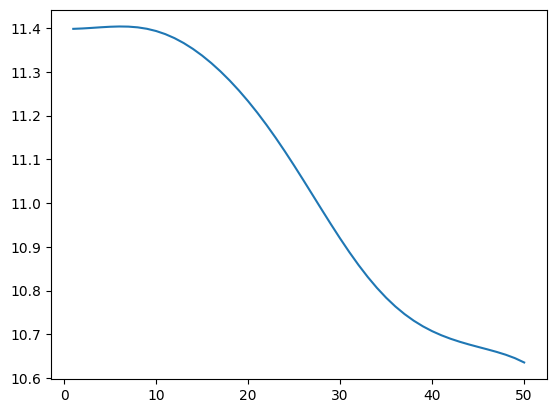

In [46]:
normalised_transverse_rpd_s8 = transverse_rpd_s8[calculation_points > 0.] / calculation_points[calculation_points > 0.]
norm_rpd_calculation_points = calculation_points[calculation_points > 0.]
plt.plot(norm_rpd_calculation_points, normalised_transverse_rpd_s8)
np.save('..\data-perpl\ACTN2-Affimer\\normalised_transverse_rpd_smoothed_Churchman-8', normalised_transverse_rpd_s8)
# normalised_transverse_rpd = np.load('normalised_transverse_rpd_smoothed_Churchman-4p4.npy')

In [47]:
(params_optimised,
 params_covar,
 params_1sd_error) = zdisk_modelling.fitmodel_to_hist(
    norm_rpd_calculation_points[0:31],
    normalised_transverse_rpd_s8[0:31],
    trans_model_with_info.model_rpd,
    trans_model_with_info.initial_params,
    trans_model_with_info.param_bounds
    )
print('')
print('Initial parameter guesses:')
print(trans_model_with_info.initial_params)
print('')
print('Parameter bounds:')
print(trans_model_with_info.param_bounds)

[[1.93394424e+01 3.27319787e-01]
 [1.37100196e+01 3.87652153e-01]
 [4.61968139e+02 3.12327165e+01]
 [6.00222293e+00 1.07923266e+00]
 [1.98664361e-01 7.64180112e-02]
 [1.04848347e+01 3.05403709e-02]]
SSR = 2.0068360197464278e-05
AIC = -427.7609525213821
AICcorr = -422.89138730399077

Initial parameter guesses:
[20, 5, 1, 3, 1, 20]

Parameter bounds:
([0, 0, 0, 0, 0, 0], [50, 20, 1000, 20, 1000, 100])


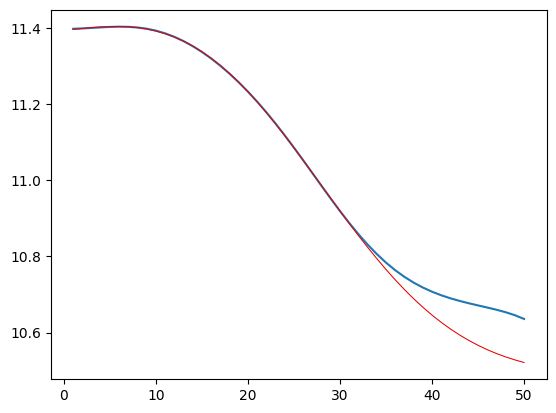

In [48]:
plt.plot(norm_rpd_calculation_points,
    normalised_transverse_rpd_s8)
zdisk_plots.plot_fitted_model(
    norm_rpd_calculation_points,
    fitlength,
    params_optimised,
    params_covar,
    trans_model_with_info,
    plot_95ci=False
    )

In [49]:
fitlength = 50.
calculation_points = np.arange(fitlength + 1.)
combined_precision=5.
transverse_rpd_s5 = plotting.estimate_rpd_churchman_2d(
    input_distances=trans_distances[trans_distances < (fitlength + 3 * combined_precision)],
    calculation_points=calculation_points,
    combined_precision=combined_precision
)

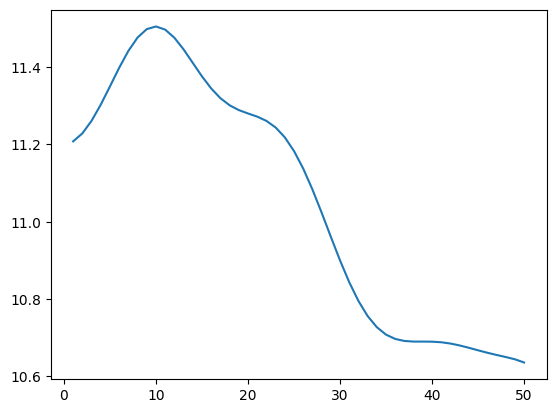

In [50]:
normalised_transverse_rpd_s5 = transverse_rpd_s5[calculation_points > 0.] / calculation_points[calculation_points > 0.]
norm_rpd_calculation_points = calculation_points[calculation_points > 0.]
plt.plot(norm_rpd_calculation_points, normalised_transverse_rpd_s5)
np.save('normalised_transverse_rpd_smoothed_Churchman-5', normalised_transverse_rpd_s5)
# normalised_transverse_rpd = np.load('normalised_transverse_rpd_smoothed_Churchman-4p4.npy')

In [51]:
fitlength = 50.
calculation_points = np.arange(fitlength + 1.)
combined_precision=6.
transverse_rpd_s6 = plotting.estimate_rpd_churchman_2d(
    input_distances=trans_distances[trans_distances < (fitlength + 3 * combined_precision)],
    calculation_points=calculation_points,
    combined_precision=combined_precision
)

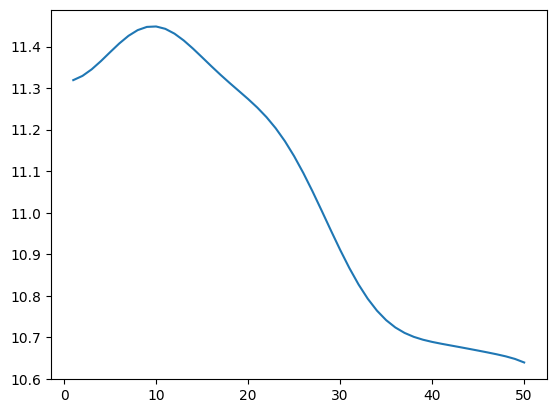

In [52]:
normalised_transverse_rpd_s6 = transverse_rpd_s6[calculation_points > 0.] / calculation_points[calculation_points > 0.]
norm_rpd_calculation_points = calculation_points[calculation_points > 0.]
plt.plot(norm_rpd_calculation_points, normalised_transverse_rpd_s6)
np.save('normalised_transverse_rpd_smoothed_Churchman-6', normalised_transverse_rpd_s6)
# normalised_transverse_rpd = np.load('normalised_transverse_rpd_smoothed_Churchman-4p4.npy')

In [53]:
(params_optimised,
 params_covar,
 params_1sd_error) = zdisk_modelling.fitmodel_to_hist(
    norm_rpd_calculation_points[0:31],
    normalised_transverse_rpd_s6[0:31],
    trans_model_with_info.model_rpd,
    trans_model_with_info.initial_params,
    trans_model_with_info.param_bounds
    )
print('')
print('Initial parameter guesses:')
print(trans_model_with_info.initial_params)
print('')
print('Parameter bounds:')
print(trans_model_with_info.param_bounds)

[[  16.20360258  117.35932649]
 [  20.          127.251572  ]
 [ 882.58557127 1673.32610815]
 [  20.          117.09096246]
 [  23.605169    287.2146786 ]
 [   9.69272233    4.37654468]]
SSR = 0.005149079401494109
AIC = -255.79066079462228
AICcorr = -250.92109557723097

Initial parameter guesses:
[20, 5, 1, 3, 1, 20]

Parameter bounds:
([0, 0, 0, 0, 0, 0], [50, 20, 1000, 20, 1000, 100])


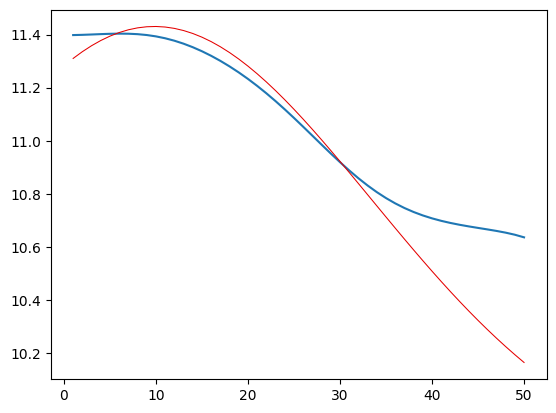

In [54]:
plt.plot(norm_rpd_calculation_points,
    normalised_transverse_rpd_s8)
zdisk_plots.plot_fitted_model(
    norm_rpd_calculation_points,
    fitlength,
    params_optimised,
    params_covar,
    trans_model_with_info,
    plot_95ci=False
    )

## Set up another model and fit
Tried a few smoothing widths again
### This model fits much better

In [55]:
trans_model_with_info = zdisk_modelling.set_up_model_2d_twopeaks_flat_bg_with_fit_settings()

In [56]:
normalised_transverse_rpd_s6 = np.load('./normalised_transverse_rpd_smoothed_Churchman-6.npy')
calculation_points = np.arange(fitlength + 1.)
norm_rpd_calculation_points = calculation_points[calculation_points > 0.]

In [57]:
(params_optimised,
 params_covar,
 params_1sd_error) = zdisk_modelling.fitmodel_to_hist(
    norm_rpd_calculation_points[0:31],
    normalised_transverse_rpd_s6[0:31],
    trans_model_with_info.model_rpd,
    trans_model_with_info.initial_params,
    trans_model_with_info.param_bounds
    )
print('')
print('Initial parameter guesses:')
print(trans_model_with_info.initial_params)
print('')
print('Parameter bounds:')
print(trans_model_with_info.param_bounds)

[[1.10972643e+01 8.35991927e-03]
 [2.38092490e+01 2.03679677e-02]
 [6.59552880e+00 7.85793612e-03]
 [1.20984129e+02 4.88657118e-01]
 [1.84130400e+02 8.07139179e-01]
 [1.06337374e+01 1.97937083e-03]]
SSR = 3.1998682683430125e-06
AIC = -484.67803170865074
AICcorr = -479.8084664912594

Initial parameter guesses:
[20, 40.0, 5, 1, 1, 20]

Parameter bounds:
([0, 0, 0, 0, 0, 0], [50, 50.0, 20, 1000, 1000, 100])


x at zero bg is -0.05775112273718555.


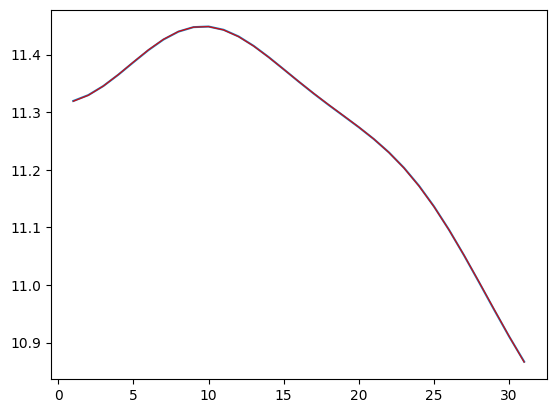

In [58]:
plt.plot(norm_rpd_calculation_points[0:31],
    normalised_transverse_rpd_s6[0:31])
zdisk_plots.plot_fitted_model(
    norm_rpd_calculation_points[0:31],
    31.,
    params_optimised,
    params_covar,
    trans_model_with_info,
    plot_95ci=True
    )

In [59]:
(params_optimised,
 params_covar,
 params_1sd_error) = zdisk_modelling.fitmodel_to_hist(
    norm_rpd_calculation_points[0:31],
    normalised_transverse_rpd[0:31],
    trans_model_with_info.model_rpd,
    trans_model_with_info.initial_params,
    trans_model_with_info.param_bounds
    )
print('')
print('Initial parameter guesses:')
print(trans_model_with_info.initial_params)
print('')
print('Parameter bounds:')
print(trans_model_with_info.param_bounds)

[[1.11808027e+01 3.21624506e-02]
 [2.41510947e+01 9.60283928e-02]
 [5.34732716e+00 4.71660544e-02]
 [1.33752043e+02 3.78975388e+00]
 [2.10641168e+02 7.86239947e+00]
 [1.05670613e+01 1.97496224e-02]]
SSR = 0.0008358348588366881
AIC = -312.1530678907884
AICcorr = -307.2835026733971

Initial parameter guesses:
[20, 40.0, 5, 1, 1, 20]

Parameter bounds:
([0, 0, 0, 0, 0, 0], [50, 50.0, 20, 1000, 1000, 100])


x at zero bg is -0.0501661729211909.


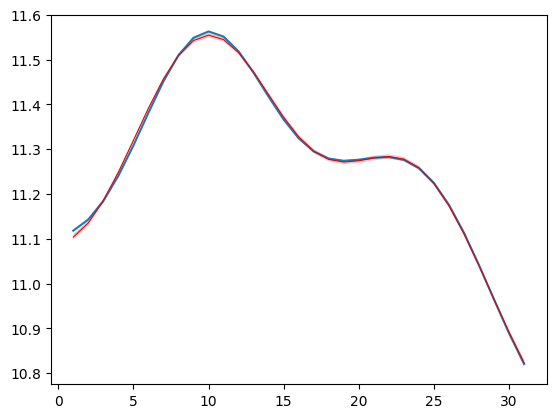

In [60]:
plt.plot(norm_rpd_calculation_points[0:31],
    normalised_transverse_rpd[0:31])
zdisk_plots.plot_fitted_model(
    norm_rpd_calculation_points[0:31],
    31.,
    params_optimised,
    params_covar,
    trans_model_with_info,
    plot_95ci=True
    )

In [66]:
normalised_transverse_rpd_s8 = np.load('./normalised_transverse_rpd_smoothed_Churchman-8.npy')
calculation_points = np.arange(fitlength + 1.)
norm_rpd_calculation_points = calculation_points[calculation_points > 0.]

FileNotFoundError: [Errno 2] No such file or directory: './normalised_transverse_rpd_smoothed_Churchman-8.npy'

In [62]:
(params_optimised,
 params_covar,
 params_1sd_error) = zdisk_modelling.fitmodel_to_hist(
    norm_rpd_calculation_points[0:31],
    normalised_transverse_rpd_s8[0:31],
    trans_model_with_info.model_rpd,
    trans_model_with_info.initial_params,
    trans_model_with_info.param_bounds
    )
print('')
print('Initial parameter guesses:')
print(trans_model_with_info.initial_params)
print('')
print('Parameter bounds:')
print(trans_model_with_info.param_bounds)

[[1.09483940e+01 5.12443115e-03]
 [2.34271340e+01 8.53029540e-03]
 [8.33728210e+00 4.78058577e-03]
 [1.12218879e+02 1.70682185e-01]
 [1.69895320e+02 1.77901446e-01]
 [1.06688857e+01 4.49174852e-04]]
SSR = 2.3687260976374447e-08
AIC = -636.761785129756
AICcorr = -631.8922199123648

Initial parameter guesses:
[20, 40.0, 5, 1, 1, 20]

Parameter bounds:
([0, 0, 0, 0, 0, 0], [50, 50.0, 20, 1000, 1000, 100])


x at zero bg is -0.06279681915615214.


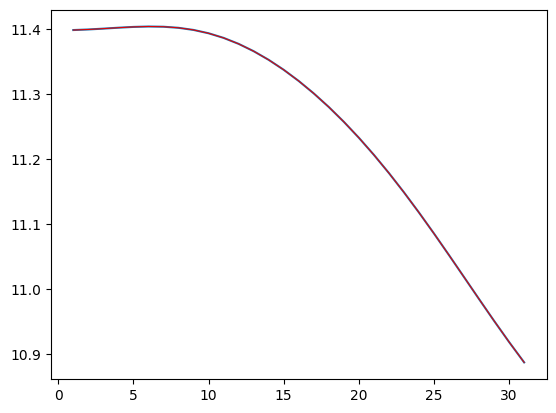

In [63]:
plt.plot(norm_rpd_calculation_points[0:31],
    normalised_transverse_rpd_s8[0:31])
zdisk_plots.plot_fitted_model(
    norm_rpd_calculation_points[0:31],
    31.,
    params_optimised,
    params_covar,
    trans_model_with_info,
    plot_95ci=True
    )

In [64]:
(params_optimised,
 params_covar,
 params_1sd_error) = zdisk_modelling.fitmodel_to_hist(
    norm_rpd_calculation_points[0:31],
    normalised_transverse_rpd_s5[0:31],
    trans_model_with_info.model_rpd,
    trans_model_with_info.initial_params,
    trans_model_with_info.param_bounds
    )
print('')
print('Initial parameter guesses:')
print(trans_model_with_info.initial_params)
print('')
print('Parameter bounds:')
print(trans_model_with_info.param_bounds)

[[1.11603027e+01 1.30711566e-02]
 [2.40419242e+01 3.66960198e-02]
 [5.80236914e+00 1.55535039e-02]
 [1.28784892e+02 1.16939663e+00]
 [1.99900005e+02 2.28217991e+00]
 [1.05942593e+01 5.64414815e-03]]
SSR = 5.02416867889432e-05
AIC = -399.3122326532046
AICcorr = -394.4426674358133

Initial parameter guesses:
[20, 40.0, 5, 1, 1, 20]

Parameter bounds:
([0, 0, 0, 0, 0, 0], [50, 50.0, 20, 1000, 1000, 100])


x at zero bg is -0.05299779411440592.


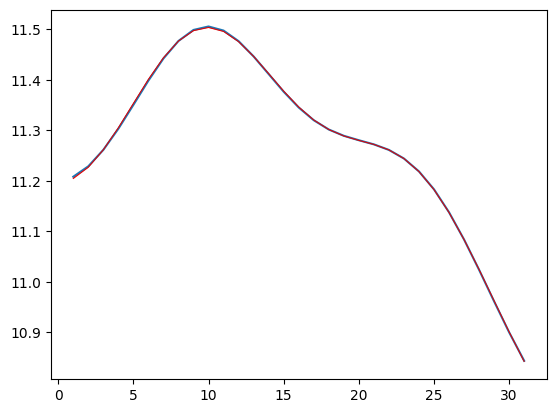

In [65]:
plt.plot(norm_rpd_calculation_points[0:31],
    normalised_transverse_rpd_s5[0:31])
zdisk_plots.plot_fitted_model(
    norm_rpd_calculation_points[0:31],
    31.,
    params_optimised,
    params_covar,
    trans_model_with_info,
    plot_95ci=True
    )